In [1]:
import os
from tqdm import tqdm
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt


import sys
sys.path.append('../scripts/')
import utils
import plot
from gan_model import CGAN

In [2]:
#Load the date from 2021
train_series, train_attr, val_series, val_attr, test_series, test_attr = utils.get_data('2021')

#Standardize the data
train_series, val_series, _, scaler_data = utils.standardize_data(train_series, val_series, test_series)

#perform one-hot encoding
ONEHOTENCODE = ['is_weekend','season','PV']
train_attr = utils.one_hot_encode_columns(train_attr, ONEHOTENCODE)
val_attr = utils.one_hot_encode_columns(val_attr, ONEHOTENCODE)
test_attr = utils.one_hot_encode_columns(test_attr, ONEHOTENCODE)

# MinMax scale the attributes -> this keeps the scales, which might be important for some attributes!
train_attr, val_attr, test_attr, scaler_attr = utils.minmax_scale_attributes(train_attr,val_attr,test_attr)

#Create dataloaders for pytorch
train_dataset = TensorDataset(torch.tensor(train_series, dtype=torch.float32), torch.tensor(train_attr, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(val_series, dtype=torch.float32), torch.tensor(val_attr, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=1028, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1028, shuffle=False)

test_attr  = torch.tensor(test_attr, dtype=torch.float32)

In [3]:
input_size = train_series.shape[1] 
condition_size = train_attr.shape[1]
latent_size = 40

RUN = 3
TITLE = 'test_run3'
RUN_OUTPUT_DIR = 'runs' + '/' + 'run'+str(RUN) + '/' + TITLE

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
CGAN = CGAN(input_size, latent_size, condition_size, device,'FCN').to(device)
CGAN.train_model(train_loader, 
                     val_loader, 
                     epochs = 1000, 
                     output_dir = RUN_OUTPUT_DIR,
                     device = device,
                     lr = 0.001)

Epoch 10/1000, D_Loss: 1.3922403480695642, G_Loss: 1.3922403480695642,  Validation D_Loss: 1.3973302125930787,  Validation G_Loss: 0.7058101296424866
Epoch 20/1000, D_Loss: 1.3879947299542634, G_Loss: 1.3879947299542634,  Validation D_Loss: 1.3890800476074219,  Validation G_Loss: 0.6958619832992554
Epoch 30/1000, D_Loss: 1.3873026992963708, G_Loss: 1.3873026992963708,  Validation D_Loss: 1.3897939205169678,  Validation G_Loss: 0.691267442703247
Epoch 40/1000, D_Loss: 1.387295847353728, G_Loss: 1.387295847353728,  Validation D_Loss: 1.3949429273605347,  Validation G_Loss: 0.6603949308395386
Epoch 50/1000, D_Loss: 1.3873363214990366, G_Loss: 1.3873363214990366,  Validation D_Loss: 1.3897242546081543,  Validation G_Loss: 0.6954039931297302
Epoch 60/1000, D_Loss: 1.3867510764495186, G_Loss: 1.3867510764495186,  Validation D_Loss: 1.3964053630828857,  Validation G_Loss: 0.7145558357238769
Epoch 70/1000, D_Loss: 1.385565970254981, G_Loss: 1.385565970254981,  Validation D_Loss: 1.401609516143

tensor([0.4358, 0.6293, 0.4770, 0.4118, 0.4333, 0.5547, 0.2400, 0.0000, 0.6000,
        0.0909, 0.6667, 0.1346, 0.2589, 0.3217, 1.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 1.0000, 0.0000, 1.0000])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


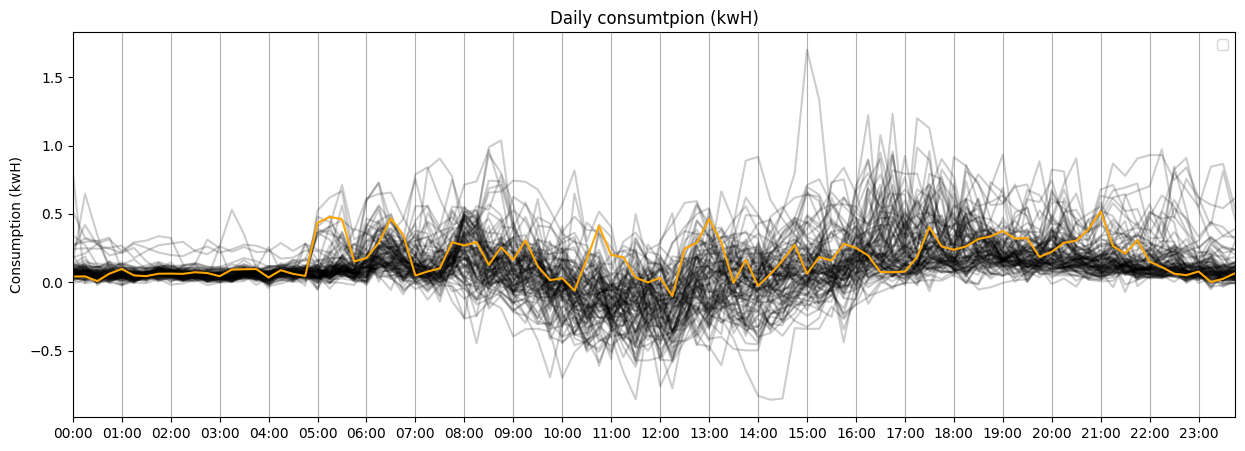

In [15]:
index = 6

samples = CGAN.generate_samples(100,test_attr[index],device)
print(test_attr[index])
samples = scaler_data.inverse_transform(samples)
plot.plotday(samples)

In [16]:
generated = []
for i, (org_serie,attr) in tqdm(enumerate(zip(test_series.values,test_attr)),total=len(test_attr)):
        new_samples = CGAN.generate_samples(1,attr,device)
        new_samples = scaler_data.inverse_transform(new_samples)
        generated.extend(new_samples)

generated_cnn = np.array(generated)

100%|██████████| 4857/4857 [00:03<00:00, 1433.71it/s]


In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def calculate_metrics_model(model, test_series, test_attr, scaler_data):
    energy_score = []
    mse = []
    mae = []
    
    for i,(org_serie,attr) in tqdm(enumerate(zip(test_series.values,test_attr)),total=len(test_attr)):
        new_samples = model.generate_samples(250,attr,device)
        new_samples = scaler_data.inverse_transform(new_samples)

        energy_score.append(utils.calculate_energy_score([1/250]*250, new_samples, org_serie))
        mse.append(mean_squared_error(new_samples,np.array([org_serie]*250)))
        mae.append(mean_absolute_error(new_samples,np.array([org_serie]*250)))

    print('Energy Score:', np.mean(energy_score))
    print('mse', np.mean(mse))
    print('mae', np.mean(mae))

In [18]:
calculate_metrics_model(CGAN,test_series,test_attr,scaler_data)

100%|██████████| 4857/4857 [00:11<00:00, 417.25it/s]

Energy Score: 0.9349722766508484
mse 0.0441806248651296
mae 0.1225503216175025


In [19]:
def calculate_mean_loadcurve(data):
    load_curves = []
    for d in data:
        shift = np.abs(np.min(d)) + 1e-6
        ts_shifted = d + shift
        ts_sorted = np.sort(ts_shifted)
        # Compute the cumulative probability of occurrence for each data point
        # cdf = np.cumsum(ts_sorted) / np.sum(ts_sorted)
        load_curves.append(ts_sorted)
    return np.mean(load_curves,axis=0)

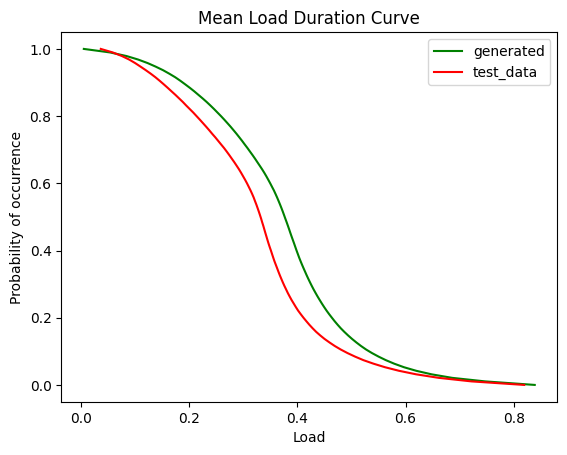

In [20]:
fig, ax = plt.subplots()

ax.plot(calculate_mean_loadcurve(generated),np.linspace(1, 0, len(calculate_mean_loadcurve(generated))), c='green',label='generated')
ax.plot(calculate_mean_loadcurve(test_series.values),np.linspace(1, 0, len(calculate_mean_loadcurve(test_series.values))), c='r',label='test_data')

# Plot the load duration curve
ax.set_xlabel('Load')
ax.set_ylabel('Probability of occurrence')
ax.set_title('Mean Load Duration Curve')
ax.legend()
plt.show()

#kernel density estimation

In [21]:
def create_quantile_plot(time_series,single_time_series=None):
    quantiles = np.arange(0.0,1.05,0.05)
    time_series_quantiles = np.quantile(time_series,quantiles,axis=0)
    timestamps = np.arange(time_series_quantiles.shape[1])
    cmap = plt.get_cmap('Blues', len(quantiles)//1.5)
    for i in range(len(quantiles)-1):
        color_idx = i if i < len(quantiles) // 2 else len(quantiles) - 2 - i
        plt.fill_between(timestamps, time_series_quantiles[i], time_series_quantiles[i + 1],
                     color=cmap(color_idx + 1), alpha=1)

    plt.xlabel('Timestamp')
    plt.ylabel('Value')
    plt.title('Time Series Quantiles (0-100)')
    if single_time_series is not None:
        plt.plot(single_time_series,c='orange')
    plt.show()

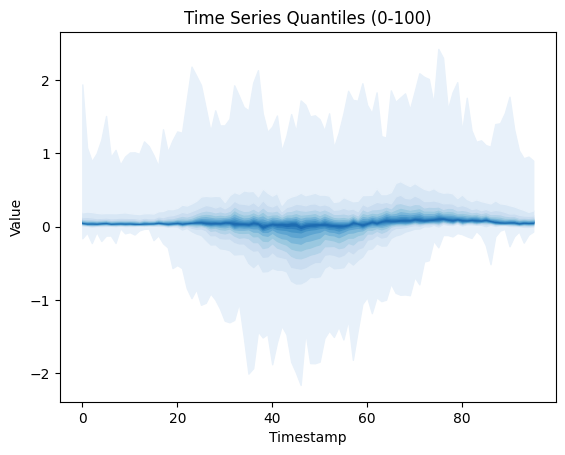

In [22]:
create_quantile_plot(generated)

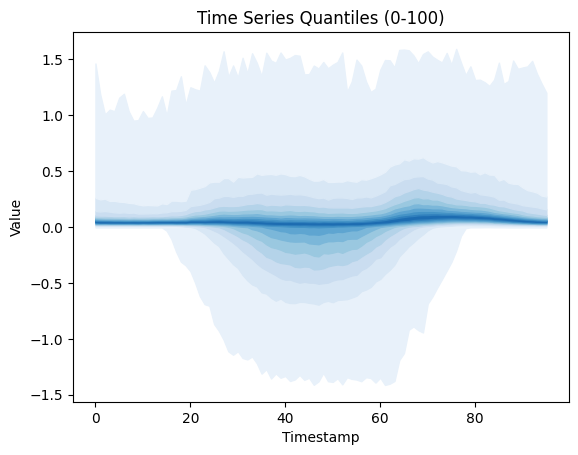

In [23]:
create_quantile_plot(test_series)

In [25]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

generated_data = np.array(generated)
combined_data = np.vstack((test_series, generated_data))

# Create labels: 0 for real, 1 for fake
labels = np.zeros((test_series.shape[0] + generated_data.shape[0],))
labels[test_series.shape[0]:] = 1

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(combined_data, labels, test_size=0.3, random_state=42)

# Train a logistic regression classifier
clf = LogisticRegression()
clf.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = clf.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

# Train an SVM classifier
clf = SVC()
clf.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = clf.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

c:\Users\jankr\miniconda3\envs\torch\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.6703259005145797
              precision    recall  f1-score   support

         0.0       0.67      0.68      0.67      1474
         1.0       0.67      0.66      0.67      1441

    accuracy                           0.67      2915
   macro avg       0.67      0.67      0.67      2915
weighted avg       0.67      0.67      0.67      2915

Accuracy: 0.8864493996569468
              precision    recall  f1-score   support

         0.0       0.91      0.86      0.88      1474
         1.0       0.87      0.91      0.89      1441

    accuracy                           0.89      2915
   macro avg       0.89      0.89      0.89      2915
weighted avg       0.89      0.89      0.89      2915

